In [2]:
import numpy as np
from rail_rl_env import RailNet, d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot, mdl_feasible, action_dict, gurobi_minlp, gurobi_nlp_presolve, gurobi_lp_presolve, gurobi_milp, num_station
import matplotlib.pyplot as plt
from rail_fun import norm_state

N=40
Env = RailNet(N)
Env.set_randState(d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot)

In [ ]:
#inspect reduced dataset

from rail_data_preprocess_reduced import get_preprocessed_data_reduced
import torch

opt = 'milp_cl'
opt_preprocess = 'reduced'
threshold_counts = 50
opt_label = 'classification'
opt_state = 4
testing = True

dict_data = get_preprocessed_data_reduced(opt, opt_preprocess, threshold_counts, N, opt_state, opt_label,testing)

N_control = dict_data['N_control']
stacked_actions_reduced_val = dict_data['stacked_actions_reduced_val']
list_masks = dict_data['list_masks']
stacked_states_val_tensor = dict_data['stacked_states_val_tensor']
input_size = dict_data['input_size']
total_action_set = dict_data['total_action_set']
state_min = dict_data['state_min']
state_max = dict_data['state_max']
stacked_states_train_tensor = dict_data['stacked_states_train_tensor']

print(stacked_states_train_tensor.shape)

num_actions = 285
number of training points (before reduction): 264562
number of validation points (before reduction): 33070
number of test points (before reduction): 33070
number of training points (after reduction): 252207
number of validation points (after reduction): 31581
number of test points (after reduction): 31756
cntr_outlier_train: 12355	 cntr_outlier_val: 1489 cntr_outlier_test: 1314
data-processing finished
torch.Size([252207, 748])


In [ ]:
#inspect original dataset

from rail_data_preprocess_reduced import get_preprocessed_data
output_get_preprocessed_data = get_preprocessed_data(opt='milp_ol', threshold_counts=25, N=N)
print(output_get_preprocessed_data[7].shape)


num_actions = 237
number of training points (before reduction): 96000
number of validation points (before reduction): 24000
number of training points (after reduction): 94871
number of validation points (after reduction): 23704
cntr_outlier_train: 1129	 cntr_outlier_val: 296
data-processing finished
torch.Size([94871, 1, 4002])


In [54]:
def downsample_average_state_rho(arr, n):
    
    """
    inputs:
        arr: is expected to be Env.state_rho with shape (num_line, pred_horizon+1, 2*num_max_stations)=(3,41,38)
        n: is the downsampling step
    
    output: is the downsized passenger flow (3,m,38) where m is floor(41/n)
    """
    
    end =  n * int(arr.shape[1]/n)
    return np.mean(arr[:,:end,:].reshape(arr.shape[0], -1, n, arr.shape[2]), 2)

In [ ]:
Env.set_randState(d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot)

(np.float64(0.048958333333333326), np.float64(0.04895833333333334))

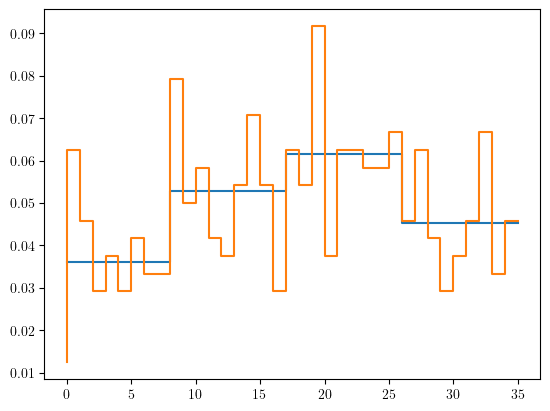

In [109]:
arr = Env.state_rho
n = 9
end =  n * int(arr.shape[1]/n)

output1 = np.zeros((Env.state_rho.shape))

output2 = downsample_average_state_rho(arr,n)

for i in range(output2.shape[1]):
    output1[:,i*n:(i+1)*n,:] = output2[:,[i],:]

x = np.arange(end)

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

line = 0
platform = 0
rho_down_vec = output1[line,:end,platform]
plt.step(x,rho_down_vec)
plt.step(x,Env.state_rho[line,:end, platform])

output1[line,:end,platform].mean(), Env.state_rho[line,:end, platform].mean()

0.605906081612451 0.605906081612451


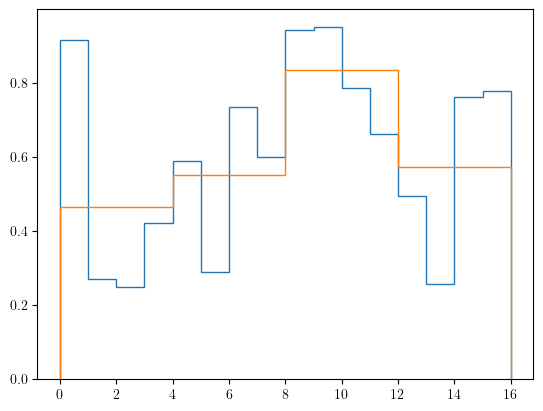

In [159]:
p_original = np.random.uniform(0.2, 1, 16)
p_reduced = np.zeros(p_original.shape)

for i in range(4):
    p_reduced[i*4:(i+1)*4] = np.mean(p_original[i*4:(i+1)*4])
print(p_original.mean(), p_reduced.mean())

plt.stairs(p_original)
plt.stairs(p_reduced)

In [161]:
tmp_list = []
for i in range(16):
    # tmp_list.append(tuple([x[i].item(), p_original[i].item()]))
    tmp_list.append(tuple([x[i].item(), p_reduced[i].item()]))
tmp_list

[(0, 0.46368655697815686),
 (1, 0.46368655697815686),
 (2, 0.46368655697815686),
 (3, 0.46368655697815686),
 (4, 0.552316526541135),
 (5, 0.552316526541135),
 (6, 0.552316526541135),
 (7, 0.552316526541135),
 (8, 0.8354481488586357),
 (9, 0.8354481488586357),
 (10, 0.8354481488586357),
 (11, 0.8354481488586357),
 (12, 0.5721730940718763),
 (13, 0.5721730940718763),
 (14, 0.5721730940718763),
 (15, 0.5721730940718763)]

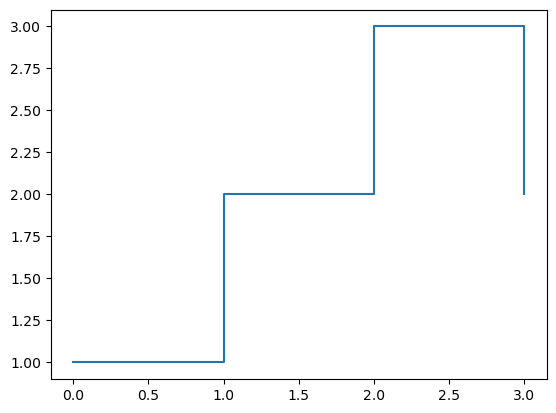

In [90]:
y = [1, 2, 3, 2]
x = [0, 1, 2, 3]

plt.step(x, y, where='post')  # 'post' or 'pre' or 'mid' depending on desired alignment
plt.show()

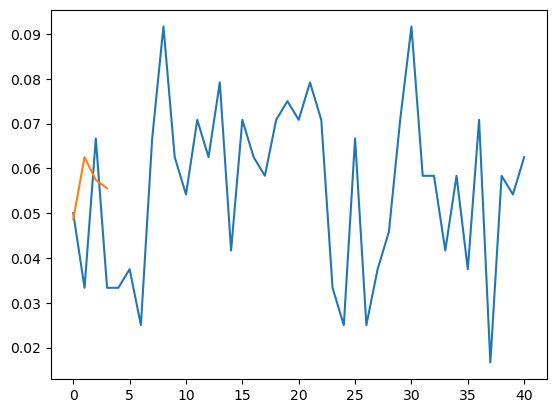

In [57]:
Env.set_randState(d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot)
line = 0
platform = 0
rho_vec = Env.state_rho[line,:,platform]
plt.plot(rho_vec)

rho_down = downsample_average_state_rho(Env.state_rho, 9)
rho_down_vec = rho_down[line,:, platform]
plt.plot(rho_down_vec)


In [4]:
tmp = np.load("data_optimal_original/data_original_milp_cl_N40_000.npy", allow_pickle=True)

In [2]:
opt_data = 'milp_cl'
idx=0
network_info_path = 'training_data_reduced//' + opt_data + '_N%d_%.3d_' %(N,idx) + 'info.npy'
tmp = np.load(network_info_path, allow_pickle=True)

In [7]:
tmp = tmp.item()

In [10]:
tmp['opt']

'milp_cl'

In [11]:
Env.state_n.shape
state_n = np.concatenate((Env.state_n[0,0:2*num_station[0]-1], Env.state_n[1,0:2*num_station[1]-1], Env.state_n[2,0:2*num_station[2]-1]))
state_n.shape

(93,)

In [12]:
from rail_data_preprocess_reduced import get_preprocessed_data_reduced

opt_preprocess = 'original'
opt_data = 'milp_ol'
N = 40
idx = 999

str_data = 'data_optimal//data_%s_%s_N%d_%.3d.npy' %(opt_preprocess, opt_data, N, idx)
array_data = np.load(str_data, allow_pickle=True)
dict_state_list = array_data[0]
dict_output_list = array_data[1]

state_n = dict_state_list['state_n']
state_depot = dict_state_list['state_depot']
idx_cntr = dict_state_list['idx_cntr']
state_l_0= dict_state_list['state_l_0']
state_l_1= dict_state_list['state_l_1']
state_l_2= dict_state_list['state_l_2']

if opt_preprocess == 'reduced':
    state_rho_down= dict_state_list['state_rho_down']
    state_rho_mean= dict_state_list['state_rho_mean']
    n_datasets = 35
elif opt_preprocess == 'original':
    state_rho = dict_state_list['state_rho']
    n_datasets = 10
    
stacked_states = np.concatenate((state_n, state_depot, idx_cntr, state_rho, state_l_0, state_l_1, state_l_2), axis=1)
        

In [13]:
state_min = np.min(stacked_states, axis=0)
state_max = np.max(stacked_states, axis=0)
stacked_states = norm_state(stacked_states, state_min, state_max)

input_size = stacked_states.shape[1]

In [38]:
from rail_fun import downsample_average_state_rho

tmp = downsample_average_state_rho(Env.state_rho, 9)

In [39]:
Env.state_rho.shape, tmp.shape

((3, 41, 38), (3, 4, 38))

In [40]:
Env.state_rho[0,1,:], tmp[0,1,:]

(array([0.04166667, 0.07083333, 0.25      , 0.31666667, 0.40833333,
        0.4875    , 0.58333333, 0.8125    , 0.90416667, 0.85      ,
        0.74583333, 0.        , 0.5       , 0.37083333, 0.74583333,
        0.58333333, 0.52083333, 0.45      , 0.3875    , 0.35833333,
        0.3       , 0.0375    , 0.02916667, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([0.02777778, 0.04490741, 0.28472222, 0.38009259, 0.44027778,
        0.51759259, 0.60648148, 0.98564815, 0.77222222, 0.84166667,
        0.8125    , 0.        , 0.51388889, 0.46342593, 0.66712963,
        0.68657407, 0.55185185, 0.45138889, 0.36759259, 0.37546296,
        0.28287037, 0.05694444, 0.02777778, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
  

In [5]:
avg_rho = np.mean(rho_whole[0], axis=2)
avg_rho.shape

(260, 38)

In [ ]:
from rail_rl_env import RailNet, gurobi_milp, gurobi_minlp, mdl_feasible, d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot, num_station
from rail_fun import downsample_average_state_rho, build_list_action

N_control = N-2
N = 40

dict_state_list = {
    'state_n' : [],
    'state_depot' : [],
    'idx_cntr' : [],
    'state_l_0' : [],
    'state_l_1' : [],
    'state_l_2' : [],
    'state_rho_down' : [],
    'state_rho_mean' : []
}

dict_output_list = {
    'delta': [],
    'list_actions': [],
    'mdl_Obj': [],
    'mdl_mipgap': [],
    'mdl_runtime': [],
    'mdl_status': []
}

def get_State(Env):
    
    state_n = np.concatenate((Env.state_n[0,0:2*num_station[0]-1], Env.state_n[1,0:2*num_station[1]-1], Env.state_n[2,0:2*num_station[2]-1]))
    state_depot = Env.state_depot

    d = {}
    # 3 is the number of time delays
    for i in range(3):
        d['state_l_' + str(i)] = np.concatenate((Env.state_l[0,i,0:2*num_station[0]-1], Env.state_l[1,i,0:2*num_station[1]-1], Env.state_l[2,i,0:2*num_station[2]-1]))
    state_l_0 = d['state_l_0']
    state_l_1 = d['state_l_1']
    state_l_2 = d['state_l_2']

    state_rho_down = downsample_average_state_rho(Env.state_rho, 9) # 4 samples of the passenger flow

    d = {}
    # 4 is the length of the downsampled state_rho
    for i in range(4):
        d[str(i)] = np.concatenate((state_rho_down[0,i,0:2*num_station[0]-1], state_rho_down[1,i,0:2*num_station[1]-1], state_rho_down[2,i,0:2*num_station[2]-1]))
    state_rho_down = np.concatenate((d['0'], d['1'], d['2'], d['3']))

    state_rho_mean = np.mean(Env.state_rho, 1)
    state_rho_mean = np.concatenate((state_rho_mean[0,0:2*num_station[0]-1], state_rho_mean[1,0:2*num_station[1]-1], state_rho_mean[2,0:2*num_station[2]-1]))

    idx_cntr = np.array([Env.idx_cntr])
    
    dict_state = {
    'state_n' : state_n,
    'state_depot' : state_depot,
    'idx_cntr' : idx_cntr,
    'state_l_0' : state_l_0,
    'state_l_1' : state_l_1,
    'state_l_2' : state_l_2,
    'state_rho_down' : state_rho_down,
    'state_rho_mean' : state_rho_mean
    }
    return dict_state

def store_State(dict, dict_state):
    for i in dict_state.keys():
        dict[i].append(dict_state[i])
        
def store_Output(dict, delta, mdl):
    dict['delta'].append(delta)
    dict['list_actions'].append(build_list_action(np.round(delta,2), N_control))
    dict['mdl_Obj'].append(np.array(mdl.ObjVal).reshape(1,))
    dict['mdl_mipgap'].append(np.array(mdl.mipgap).reshape(1,))
    dict['mdl_runtime'].append(np.array(mdl.runtime).reshape(1,))
    dict['mdl_status'].append(np.array(mdl.status).reshape(1,))    

In [6]:
import numpy as np
a = np.zeros((3,1))
a[0] = True

a=0; b=0; c=0; d=1
tmp = (a or b)==True or (c or d)==True
tmp

True

In [3]:
# 0-10 - peak hours morning
# 11 empty
# 12-22 - peak hours evening


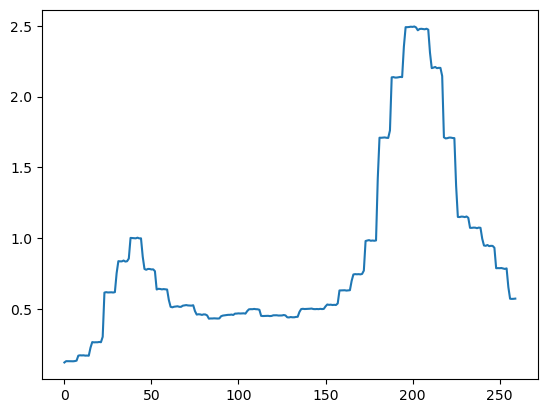

In [4]:
plt.plot(avg_rho[:,17])

In [3]:
import numpy as np
N=40
opt = 'milp_ol'
array_data = np.load('data_optimal_reduced//data_reduced_%s_N%.2d_%.3d.npy' %(opt, N, 0), allow_pickle=True)
for job_idx in range(1,25):
    tmp_vector = np.load('data_optimal_reduced//data_reduced_%s_N%.2d_%.3d.npy' %(opt,N, job_idx), allow_pickle=True)
    array_data = np.concatenate((array_data, tmp_vector))
# minlp_info_compressed = minlp_info_compressed[:120000, :]
np.save('data_optimal_reduced//data_reduced_%s_N%.2d_condensed.npy' %(opt,N), array_data, allow_pickle=True)

In [3]:
import numpy as np

opt_data = 'milp_ol'
opt_label = 'classification'

str_data = 'data_optimal_reduced//data_reduced_%s_N%d_%.3d.npy' %(opt_data, N, 0) # for testing
array_data = np.load(str_data, allow_pickle=True)
dict_state_list = array_data[0]
dict_output_list = array_data[1]

state_n = dict_state_list['state_n']
state_depot = dict_state_list['state_depot']
idx_cntr = dict_state_list['idx_cntr']
state_rho_down= dict_state_list['state_rho_down']
state_rho_mean= dict_state_list['state_rho_mean']
state_l_0= dict_state_list['state_l_0']
state_l_1= dict_state_list['state_l_1']
state_l_2= dict_state_list['state_l_2']
if opt_label=='classification':
        stacked_list_actions = dict_output_list['list_actions']
elif opt_label=='regression':
        stacked_list_actions = dict_output_list['delta']
for i in range(1,25):
    str_data = 'data_optimal_reduced//data_reduced_%s_N%d_%.3d.npy' %(opt_data, N, i) # for testing
    array_data = np.load(str_data, allow_pickle=True)
    dict_state_list = array_data[0]
    dict_output_list = array_data[1]
    
    state_n = np.concatenate((state_n, dict_state_list['state_n']))
    state_depot = np.concatenate((state_depot, dict_state_list['state_depot']))
    idx_cntr = np.concatenate((idx_cntr, dict_state_list['idx_cntr']))
    state_rho_down= np.concatenate((state_rho_down, dict_state_list['state_rho_down']))
    state_rho_mean= np.concatenate((state_rho_mean, dict_state_list['state_rho_mean']))
    state_l_0= np.concatenate((state_l_0, dict_state_list['state_l_0']))
    state_l_1= np.concatenate((state_l_1, dict_state_list['state_l_1']))
    state_l_2= np.concatenate((state_l_2, dict_state_list['state_l_2']))
    
    if opt_label=='classification':
        tmp = dict_output_list['list_actions']
    elif opt_label=='regression':
        tmp = dict_output_list['delta']    
    stacked_list_actions = np.concatenate((stacked_list_actions, tmp))

In [9]:
state_rho_mean.shape, state_l_0.shape, state_n.shape

((4827, 93), (4827, 93), (109364, 93))

In [6]:
state_rho_mean= dict_state_list['state_rho_mean']
state_l_0= dict_state_list['state_l_0']
stacked_states = np.concatenate((state_n, state_depot, idx_cntr, state_rho_mean, state_l_0), axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 109364 and the array at index 3 has size 4827

In [2]:
array_data = np.load('data_optimal_reduced//data_reduced_%s_N%.2d_%.3d.npy' %(opt, N, 0), allow_pickle=True)
dict_state_list = array_data[0]
dict_output_list = array_data[1]

dict_state_list

NameError: name 'np' is not defined

In [14]:
opt = 'milp_cl'
array_data = np.load('data_optimal//data_%s_N%.2d_999.npy' %(opt, N), allow_pickle=True)

In [1]:
opt_data = 'milp_ol'
threshold_counts = 50
N = 40
opt_state=1
opt_label='classification'
testing=True

from rail_data_preprocess_reduced import get_preprocessed_data_reduced

dict_data = get_preprocessed_data_reduced(opt_data, threshold_counts, N, opt_state, opt_label, testing)

stacked_states_val_tensor = dict_data['stacked_states_val_tensor']
stacked_states_val_tensor.shape

num_actions = 269
number of training points (before reduction): 313528
number of validation points (before reduction): 39191
number of test points (before reduction): 39190
number of training points (after reduction): 311344
number of validation points (after reduction): 38912
number of test points (after reduction): 38908
cntr_outlier_train: 2184	 cntr_outlier_val: 279 cntr_outlier_test: 282
data-processing finished


torch.Size([38912, 283])

In [2]:
N_control = dict_data['N_control']
stacked_actions_reduced_val = dict_data['stacked_actions_reduced_val']
list_masks = dict_data['list_masks']
stacked_states_val_tensor = dict_data['stacked_states_val_tensor']
input_size = dict_data['input_size']
total_action_set = dict_data['total_action_set']

In [10]:
batch_size = 32
device='cpu'
import torch
import numpy as np

stacked_actions_reduced_train = dict_data['stacked_actions_reduced_train']
stacked_actions_reduced_val = dict_data['stacked_actions_reduced_val']
stacked_states_train_tensor = dict_data['stacked_states_train_tensor']
stacked_states_val_tensor = dict_data['stacked_states_val_tensor']
batch = np.random.choice(stacked_states_train_tensor.shape[0], batch_size, replace=False)

from rail_training_reduced import build_pad_batch_states_tensor

b = torch.zeros(batch_size, N_control-1, input_size)
state_batch_train = build_pad_batch_states_tensor(stacked_states_train_tensor[batch].unsqueeze(dim=1), batch_size, input_size, N_control).to(device)

In [9]:
b = torch.zeros(batch_size, N_control-1, input_size)
stacked_states_train_tensor[batch].shape, b.shape

(torch.Size([32, 748]), torch.Size([32, 37, 748]))

In [2]:
a=23.258
print('%.2d' %a)

23


In [28]:
m=238
n=32

4*(m*n+n**2+n) + n*200

41088

In [9]:
hidden_size = 32
dropout = 0.5
num_layers=1
lr=1e-4
batch_size=32

opt_data='milp_cl'

dict_data = get_preprocessed_data_reduced(opt_data, threshold_counts, N, opt_state, opt_label,testing)

N_control = dict_data['N_control']
stacked_actions_reduced_val = dict_data['stacked_actions_reduced_val']
list_masks = dict_data['list_masks']
stacked_states_val_tensor = dict_data['stacked_states_val_tensor']
input_size = dict_data['input_size']
total_action_set = dict_data['total_action_set']

num_actions = total_action_set.shape[0]

num_actions = 285
number of training points (before reduction): 264562
number of validation points (before reduction): 33070
number of test points (before reduction): 33070
number of training points (after reduction): 252207
number of validation points (after reduction): 31581
number of test points (after reduction): 31756
cntr_outlier_train: 12355	 cntr_outlier_val: 1489 cntr_outlier_test: 1314
data-processing finished


In [ ]:
from rail_training_reduced import Network, Network1, Network2
network = Network1(input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout)

In [6]:
import torch

input = torch.randn(batch_size, N, input_size)
h0 = torch.randn(num_layers, batch_size, hidden_size)
c0 = torch.randn(num_layers, batch_size, hidden_size)

network_out = network(input,h0,c0)

In [16]:
32*40*94

120320

In [7]:
network_out.shape

torch.Size([32, 40, 285])

In [10]:
import numpy as np

tmp = np.load('training_data_reduced/milp_cl_N40_hyperparm_set.npy', allow_pickle=True).item()

In [12]:
idx=1
tmp[str(idx)][-1]

2

In [1]:
from rail_fun import get_State, norm_state
from rail_rl_env import RailNet, d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot
from rail_data_preprocess_reduced import get_dataset_min_max
import numpy as np

N = 40
idx = 4
opt_data = 'milp_cl'
threshold_counts = 50
opt_state=1
opt_label='classification'
testing=True

tmp = np.load('training_data_reduced/milp_cl_N40_hyperparm_set.npy', allow_pickle=True).item()
opt_state = tmp[str(idx)][-1]
    
dict_data = get_dataset_min_max(opt_data, threshold_counts, N, testing)

N_control = dict_data['N_control']
list_masks = dict_data['list_masks']
total_action_set = dict_data['total_action_set']
state_min = dict_data['state_min_%d' %opt_state]
state_max = dict_data['state_max_%d' %opt_state]
input_size = dict_data['input_size_%d' %opt_state]

num_actions = 285


In [2]:
import torch
from rail_fun import get_state_learning

N = 40
Env = RailNet(N)
Env.set_randState(d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot)
state_learning = get_state_learning(Env, opt_state, state_min, state_max, N_control)

In [3]:
state_learning.shape

torch.Size([1, 38, 283])

In [ ]:
from rail_fun import cost_per_step, build_delta_vector, get_state_learning
import numpy as np
from rail_rl_env import RailNet, d_pre, rho_whole, un, ul, uy, ua, ud, ur, depot, mdl_feasible, action_dict, gurobi_minlp, gurobi_nlp_presolve, gurobi_lp_presolve, gurobi_milp
import time
from rail_data_preprocess_reduced import get_dataset_min_max
from rail_training_reduced import Network, Network_CE, Network_mask1, Network_mask2, Network_mask3
import torch
import sys
import datetime

x = datetime.datetime.now()
date_str = '%.2d%.2d_%.2d%.2d' %(x.month, x.day, x.hour, x.minute)
print('date_time: ' + date_str)

start_loop = time.time()

# added by Xiaoyu
match_nlp = np.zeros(3, dtype=int)
match_lp = np.zeros(3, dtype=int)
match_constant = np.zeros(3, dtype=int)
match_constant[0] = 21 # 4 x 21: time for the train to return the first station (from the original timetable)
match_constant[1] = 27
match_constant[2] = 23

N = 40
testing = True

opt_label = 'classification' #(regression is not implemented yet)

if testing == True:
    import psutil
    p = psutil.Process()
    opt_data = 'milp_cl'
    idx = 1
    n_threads = 8
    timeout = 30*60 #minutes
    timelimit_gurobi = 30
    timelimit_reference = 30 # sets the time for the longest milp (with warm-start)
else:
    opt_data = sys.argv[1]
    n_threads = int(sys.argv[2])
    timelimit_job = int(sys.argv[3]) #(in seconds)
    idx = int(sys.argv[4])
    timelimit_gurobi = 60 # (in seconds, for minlp and milp)
    timeout = timelimit_job - 30*60
    
device='cpu'
torch.set_num_threads(n_threads)

num_layers=1
lr=1e-3
batch_size=1 #
threshold_counts = 50

mipgap = 1e-3
log = 0
early_term = 1

print('N: %d \t mipgap: %.4f \t timelimit_gurobi: %.2f \t n_threads: %d \t early_term: %d' %(N, mipgap, timelimit_gurobi, n_threads, early_term))
print('opt_data: ' + opt_data + '\t threshold counts: %d' %threshold_counts)
print('timeout: %.2f,\t' %timeout, 'mipgap %.4f' %mipgap)
    
dict_data = get_dataset_min_max(opt_data, threshold_counts, N, testing)

N_control = dict_data['N_control']
list_masks = dict_data['list_masks']
total_action_set = dict_data['total_action_set']

action_dict_reduced = {}
for i in total_action_set:
    action_dict_reduced[str(i)] = action_dict[str(i)]

num_actions = total_action_set.shape[0]
seq_len=N_control

seed = 4
np.random.seed(seed)
torch.manual_seed(seed)

##################

idx_best_networks = [51, 17, 21, 55, 49, 23, 19, 53, 61, 29, 25, 27, 57, 59, 31]
num_networks = len(idx_best_networks)

def build_network(network_type, input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout, list_masks=list_masks, device=device):
    if network_type == 'Network':
        network = Network(input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout)
    elif network_type == 'Network_CE':
        network = Network_CE(input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout)
    elif network_type == 'Network_mask1':
        network = Network_mask1(input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout, list_masks, device)
    elif network_type == 'Network_mask2':
        network = Network_mask2(input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout, list_masks, device)
    elif network_type == 'Network_mask3':
        network = Network_mask3(input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout, list_masks, device)
    else:
        raise KeyError('Network type has not been found.')
    
    return network

if testing==True:
    hyperpar_set = np.load('training_data_reduced/milp_cl_N40_hyperparm_set.npy', allow_pickle=True).item()
else:
    hyperpar_set = np.load('//scratch/cfoliveiradasi//railway_largescale//training_data_reduced//milp_cl_N40_hyperparm_set.npy', allow_pickle=True).item()

model_list = []
h0 = []
c0 = []
opt_state = []
state_min = []
state_max = []
for idx in idx_best_networks:
    
    if testing==True:
        network_info_path = 'training_data_reduced//' + opt_data + '_N%d_%.3d_' %(N,idx) + 'info.npy'
        network_weight_path = 'training_data_reduced//' + opt_data + '_N%d_%.3d_' %(N,idx) + 'weight'
    else:
        network_info_path = '//scratch/cfoliveiradasi//railway_largescale//training_data_reduced//%s_N%.2d_%.3d_info.npy' %(opt_data, N, idx)
        network_weight_path = '//scratch/cfoliveiradasi//railway_largescale//training_data_reduced//%s_N%.2d_%.3d_weight' %(opt_data, N, idx)
        
    opt_state.append(hyperpar_set[str(idx)][-1])
    state_min.append(dict_data['state_min_%d' %opt_state[-1]])
    state_max.append(dict_data['state_max_%d' %opt_state[-1]])
        
    network_info = np.load(network_info_path, allow_pickle=True).item()    
    network_type = network_info['network_type']
    input_size = network_info['input_size']
    hidden_size = network_info['hidden_size']
    num_layers = network_info['num_layers']
    lr = network_info['lr']
    dropout = network_info['dropout']
    LR_scheduler = network_info['LR_scheduler']
    
    network = build_network(network_type, input_size, hidden_size, num_layers, lr, num_actions, batch_size, dropout)
    network.load_state_dict(torch.load(network_weight_path, weights_only=True))
    
    h0.append(torch.zeros(num_layers, 1, hidden_size))
    c0.append(torch.zeros(num_layers, 1, hidden_size))
    
    model_list.append(network)

date_time: 0209_2057
N: 40 	 mipgap: 0.0010 	 timelimit_gurobi: 30.00 	 n_threads: 8 	 early_term: 1
opt_data: milp_cl	 threshold counts: 50
timeout: 300.00,	 mipgap 0.0010
num_actions = 285
4 51 (748,) (748,)
2 17 (469,) (469,)
2 21 (469,) (469,)
4 55 (748,) (748,)
2 49 (469,) (469,)
4 23 (748,) (748,)
4 19 (748,) (748,)
2 53 (469,) (469,)
2 61 (469,) (469,)
2 29 (469,) (469,)
2 25 (469,) (469,)
4 27 (748,) (748,)
2 57 (469,) (469,)
4 59 (748,) (748,)
4 31 (748,) (748,)
opt_data: milp_cl, opt_state 4, network_type: Network, hidden_size: 256, dropout: 0.50, seed: 4, idx: 31, n_threads: 8, LR_scheduler: 1
lr: 0.00100, batch_size: 1, threshold_counts: 50, N: 40
number of parameters:  791325


In [1]:
class Env():
    def __init__(self):
        Env.a = 0
        
env = Env()

print(env.a)
def test_fun(env):    

    env.a = 4
    # return tmp
test_fun(env)
print(env.a)

0
4
